In [40]:
%load_ext autoreload
%autoreload 2

import os
import sys
import yaml
import numpy as np
import matplotlib.pyplot as plt
import torch

sys.path.append(os.path.join('..'))
from model import GreyboxModel

# load experiment parameters
exptname = 'pendulum'
mode = 'adaptive'
trialname = 'demo'
with open(os.path.join('..', 'params.yaml'), 'r') as fd:
    params = yaml.safe_load(fd)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Preparation

In [41]:
# load log
with np.load(os.path.join('..', 'out', trialname, mode, 'curve_tr.npz')) as data:
    L_tr = data['L_tr']
    L_va = data['L_va']

# load all data
with np.load(os.path.join('..', 'out', trialname, 'data_va.npz')) as data:
    x = data['x']
    y = data['y']
with np.load(os.path.join('..', 'out', trialname, 'data_tr.npz')) as data:
    x = np.concatenate((x, data['x']), axis=0)
    y = np.concatenate((y, data['y']), axis=0)
ymax = np.max(y)
ymin = np.min(y)

# load model
model = GreyboxModel(params['model'])
model.load_state_dict(torch.load(os.path.join('..', 'out', trialname, mode, 'model_te.pt')))
model.eval()

GreyboxModel(
  (net_fD): Sequential(
    (0): Linear(in_features=6, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.01, inplace=True)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): Linear(in_features=128, out_features=2, bias=True)
  )
)

### Inspect learning curves

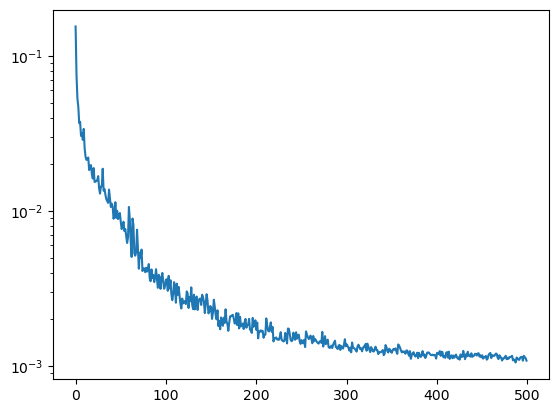

In [42]:
epochs_tr = np.array(list(range(0, L_tr.shape[0])))
# epochs_va = np.array(list(range(0, L_tr.shape[0], params['train']['valid_interval_epochs'])))

plt.plot(epochs_tr, np.mean(L_tr, axis=1))
# plt.plot(epochs_va, np.mean(L_va, axis=1))
plt.yscale('log')
# plt.legend(['train', 'validation'])
plt.show()

### Plot results for different [g,l]

In [43]:
gg = np.linspace(8.0, 12.0, 101)

nrmse = np.zeros_like(gg)
normT = np.zeros_like(gg)
normD = np.zeros_like(gg)
abs_dotTD = np.zeros_like(gg)
for i in range(gg.shape[0]):
    g = gg[i]

    # prediction on test data
    with torch.no_grad():
        _thT = torch.tensor([g]).float().view(1,-1)
        yh, _normT, _normD, _abs_dotTD = model(torch.tensor(x), thT=_thT, return_all_R=True)
    yh = yh.detach().numpy()

    # store results
    nrmse[i] = np.sqrt(np.mean((yh-y)**2)) / (ymax - ymin)
    normT[i] = _normT.item()
    normD[i] = _normD.item()
    abs_dotTD[i] = _abs_dotTD.item()

Parameter containing:
tensor([[10.2556]], requires_grad=True)


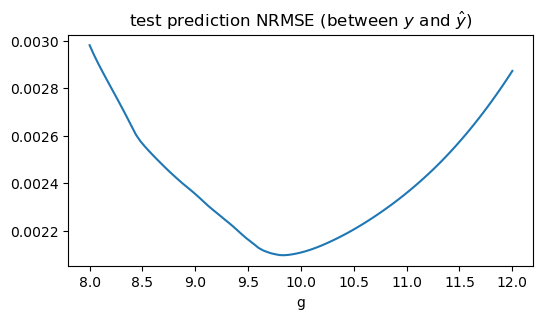

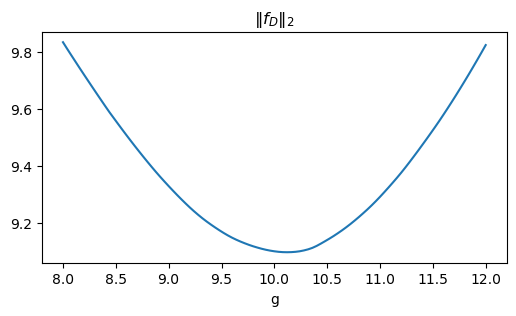

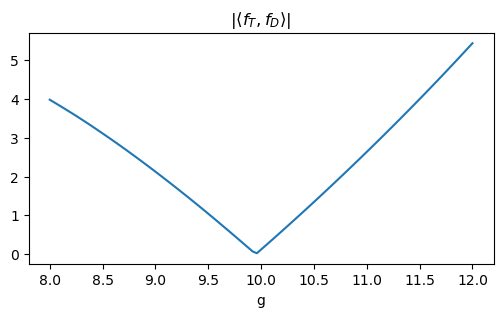

In [44]:
targets_and_names = [
    (nrmse, r'test prediction NRMSE (between $y$ and $\hat{y}$)'),
    (normD, r'$\Vert f_D \Vert_2$'),
    (abs_dotTD, r'$| \langle f_T, f_D \rangle |$'),
]

print(model.prm_thT_fixed)

for target_and_name in targets_and_names:
    plt.figure(figsize=(6,3))
    plt.plot(gg, target_and_name[0])
    plt.xlabel('g')
    plt.title(target_and_name[1])
    plt.show()

In [45]:
np.savetxt('../../pendulum_Rmap.txt', np.concatenate((
    gg[:,np.newaxis],
    np.sqrt(normD)[:,np.newaxis],
    abs_dotTD[:,np.newaxis],
    nrmse[:,np.newaxis]*100
), axis=1), header='thT normD abs_dotTD nrmse_prc', comments='')